# Libraries, loading data

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
drive_folder=  "/content/drive/MyDrive/Colab_Notebooks/Project_6"
os.chdir(drive_folder)
os.listdir()

Mounted at /content/drive


['objectifs.pdf',
 'Copie de Weather_Images_CNN_Transfer_Learning_Stage_1_feasibility_V1.0.ipynb',
 'Copie de P6_03_NLP_optim_description.ipynb',
 'Copie de P6_06_IMAGES_Transfert_learning.ipynb',
 'Copie de P6_02_NLP_optim_product_name.ipynb',
 'Copie de P6_07_Faisabilité.ipynb',
 'Copie de P6_05_IMAGES_SIFT_ORB.ipynb',
 'Copie de P6_01_NLP.ipynb',
 'Flipkart',
 'NLP',
 'Weather_Images_CNN_Transfer_Learning_Stage_1_feasibility_V1.0.ipynb',
 'BERT',
 'Copie de P6_04_NLP_TRANSFERT_BERT_tensorflow_full_model.ipynb',
 'FlipKart_NLP.pkl',
 'FEAT_TFIDF_PRODUCT_NAME',
 'FEAT_TFIDF_DESCRIPTION',
 'Flip_opt.data',
 'Flip_opt.cat',
 'DOC2VEC',
 'USE',
 'P6_NLP_optim_product_name.ipynb',
 'P6_NLP_optim_description.ipynb',
 'P6_06_Faisabilité.ipynb',
 'P6_02_NLP_Doc2Vec.ipynb',
 'Copie de EDIT_P6_04_IMAGES_SIFT_ORB.ipynb',
 'P6_01_NLP_Basic_methods.ipynb',
 'P6_04_IMAGES_SIFT_ORB.ipynb',
 'P6_03_NLP_transfer_learning.ipynb',
 'P6_05_IMAGES_Transfert_learning.ipynb']

In [2]:
import time,datetime
start_time = time.time()

In [3]:
import numpy as np
import pandas as pd

import re
import nltk

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
# import dataprep.eda as eda
# import qgrid
import plotly.express as px
from tqdm.notebook import tqdm
import os

bleu = (70 / 255, 130 / 255, 180 / 255)
pd.set_option('display.max_row', 50)
pd.set_option('display.max_column', 50)
pd.set_option('display.max_colwidth', 50)

In [4]:
import joblib

data = joblib.load('Flip_opt.data')
cat = joblib.load('Flip_opt.cat')

In [5]:
data.head()

,category,cat_code,product_name,description,product_name_prep,description_prep,complete_description,complete_description_prep
0,Furniture,0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,polyest curtain abstract eyelet door multicolo...,style curtaineleg look shrinkag apart sun dust...,Elegance Polyester Multicolor Abstract Eyelet ...,style curtaineleg look shrinkag apart sun dust...
1,Baby,1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,cotton towel sathiya bath,bath cotton general specif yes mediam box leng...,Sathiyas Cotton Bath Towel Specifications of S...,bath cotton general specif yes mediam box leng...
2,Baby,1,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,set eurospa terri face cotton towel,export shrinkag eurospa box weight materi sale...,Eurospa Cotton Terry Face Towel Set Key Featur...,export shrinkag eurospa box weight materi sale...
3,Furniture,0,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,print doubl santosh size fashion cotton bedshe...,fabric cm cotton key general bleach depth gold...,SANTOSH ROYAL FASHION Cotton Printed King size...,fabric cm cotton key general bleach depth gold...
4,Furniture,0,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,print doubl size cotton bedsheet floral jaipur...,fabric product comfort cm cottonjaipur lifespe...,Jaipur Print Cotton Floral King sized Double B...,fabric product comfort cm cottonjaipur lifespe...


In [6]:
cat

,category,count
0,Furniture,150
1,Baby,150
2,Watches,150
3,Decor,150
4,Kitchen,150
5,Beauty,150
6,Computers,150


Fonctions d'évaluation

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# Import KMeans clusterer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score


from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from scipy.optimize import linear_sum_assignment

from sklearn.feature_extraction.text import TfidfTransformer


In [8]:
# Resumption of all results evaluation steps

from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
from scipy.optimize import linear_sum_assignment
from collections import Counter

# Plot confusion matrix with better cmap look.
def plot_conf_mat(matrix,y_names,x_names,title=''):
    fig,axe=plt.subplots(figsize=(8,6))

    sns.heatmap(matrix, annot=True, cmap='Accent',ax=axe, square=True,fmt='g',vmin=0,vmax=150)
    axe.set_yticklabels(y_names,rotation = 0,fontsize=11)
    axe.set_xticklabels(x_names, rotation = 45, ha="right",fontsize=11)
    axe.set_title(title,fontsize=16)
    plt.show()



"""
Main function.
Evaluates clustering performance by comparing predicted cluster labels with ground truth labels.

This function performs several key evaluation steps:
1. Counts the frequency of each cluster
2. Computes a confusion matrix between predicted clusters and true categories
3. Optimizes cluster-to-category alignment using the Hungarian algorithm
4. Visualizes the aligned confusion matrix
5. Calculates the Adjusted Rand Index (ARI) to measure clustering quality
6. Generates a detailed classification report with precision, recall, and F1-score

Parameters:
    pred_labels (array-like): Predicted cluster labels from clustering algorithm
    true_labels (array-like): Ground truth category labels
    cat_names (list): List of category names for visualization and reporting

Returns:
    tuple: ((precision, recall, f1, support), ari) - Macro-averaged metrics and ARI score
"""
def clustering_evaluate(pred_labels, true_labels, cat_names):

    # Count clusters effectives
    effectives=dict(sorted(Counter(pred_labels).items()))

    # compute confusion matrix
    conf_mat=confusion_matrix(true_labels,pred_labels)

    # Plot confusion matrix
#     plot_conf_mat(conf_mat,cat['index'],range(7),title='Confusion matrix')

    # Maximize values on first diagonal
    row_ind, col_ind = linear_sum_assignment(conf_mat,maximize=True)
    permut = pd.DataFrame(col_ind,index=cat['category'],columns=['cluster'])
    permut.index.rename('Category',inplace=True)
    permut['effectives']=[effectives[cls] for cls in permut.cluster]
    display(permut)
    cm=conf_mat.take(col_ind,axis=1)

    # Plot aligned confusion matrix
    plot_conf_mat(cm,cat_names,cat_names,title='Aligned confusion matrix')

    # Align cluster label on category code   [corresp[cls] for cls in labels]
    corresp = np.argmax(conf_mat, axis=0)

    # print  adjusted rand score
    ari = adjusted_rand_score(true_labels,pred_labels)
    print(' ARI : {}'.format(ari))

    # Print classification report
    print(classification_report(true_labels,
                                [corresp[cls] for cls in pred_labels],
                                target_names=cat_names,
                                zero_division=0)
         )
    return  precision_recall_fscore_support(true_labels,
                                [corresp[cls] for cls in pred_labels],
                                             average='macro', zero_division=0), ari


# 2D projection scatterplot
def plot_clusters(reduced,labels):
    data=pd.DataFrame(np.c_[reduced,labels],columns=['Component 1','Component 2','Cluster'])

    plt.figure(figsize=(10,8))
    sns.scatterplot(data=data,
                    x='Component 1',
                    y='Component 2',
                    hue='Cluster',
                    palette=sns.color_palette('tab10', n_colors=7))
    plt.title(f'')
    plt.figure(figsize=(10,8))

In [9]:
# Dictionaries to hold results
# Function to append results to result_dict
def append_dict(dict1_obj, dict2_obj):
    for key in dict1_obj.keys():
        dict1_obj[key].append(dict2_obj[key])

# Tensorflow

In [10]:
import tensorflow_text as text  # Registers the ops.

In [11]:
import tensorflow as tf
import tensorflow_hub as hub # Always necessary for the preprocessor

In [12]:
print("TF version: ", tf.__version__)
print("TF HUB version: ", hub.__version__)

TF version:  2.18.0
TF HUB version:  0.16.1


In [13]:
# To process several sentences at once
sentences = [
    "Première phrase d'exemple.",
    "Deuxième phrase à analyser.",
    "Une troisième phrase pour tester le batch processing."
]

## BERT setup
Set up model: importing preprocessor and bert model from TensorHub.

Preprocessor input could be a list of sentences. The output is the input of the BERT model:

Inputs:
 - `input_word_ids`: input token ids (tokenizer converts tokens using vocab file)
 - `input_mask`: input masks (1 for useful tokens, 0 for padding)
 - `input_type_ids`: segment ids (for 2 text training: 0 for the first one, 1 for the second one)

Outputs:
 - `pooled_output` of shape `[batch_size, 768]` with representations for the entire input sequences
 - `sequence_output` of shape `[batch_size, max_seq_length, 768]` with representations for each input token (in context)

For changing the `max_seq_length`, see the preprocessor model's documentation or the corresponding section below.


In [14]:
# Load BERT preprocessor separately
preprocessor = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

# Load BERT encoder separately
encoder = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

# Example of use with an individual sentence
sentence = "Here is an example of a sentence to be processed with BERT."

# Preprocess sentence
# Note: We wrap the sentence in a list because the preprocessor is waiting for a batch.
encoder_inputs = preprocessor([sentence])

# Check the structure of pre-processed inputs
print("Preprocessor input structure:")
for key, value in encoder_inputs.items():
    print(f"  {key}: shape {value.shape}, dtype {value.dtype}")

# Pass pre-processed inputs to BERT encoder
outputs = encoder(encoder_inputs)

# Get sentence embedding (pooled_output)
embedding = outputs["pooled_output"]
print(f"\nEmbedding shape: {embedding.shape}")  # Devrait être (1, 768)

# Example of use with your line of code
sentence = "Another sentence to analyze."
encoder_inputs = preprocessor([sentence])

# Process the entire batch directly
batch_inputs = preprocessor(sentences)
batch_outputs = encoder(batch_inputs)
batch_embeddings = batch_outputs["pooled_output"]
print(f"\nEmbeddings de batch shape: {batch_embeddings.shape}")  # Should be (3, 768)

# define a function assembling all previous steps
# inptut a sentence ouputs embedded vector
def bertize(sentence):
    encoder_inputs = preprocessor([sentence])
    outputs = encoder(encoder_inputs)
    pooled_output = outputs["pooled_output"]

    return pooled_output.numpy().reshape(-1)


Preprocessor input structure:
  input_type_ids: shape (1, 128), dtype <dtype: 'int32'>
  input_mask: shape (1, 128), dtype <dtype: 'int32'>
  input_word_ids: shape (1, 128), dtype <dtype: 'int32'>

Embedding shape: (1, 768)

Embeddings de batch shape: (3, 768)


Load sentence to the preprocessor model and generate inputs for the BERT model. It results with a dict of 3 outputs, tokenized, truncated, padded to the shape expected by the model.

In [15]:
sentence = "This is a nice sentence."

The token id `101` and `102` correspond to the `[CLS]` and `[SEP]` tokens respectively.

In [16]:
encoder_inputs = preprocessor([sentence])
encoder_inputs

{'input_type_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 

Generate BERT embedding vectors

In [17]:
outputs = encoder(encoder_inputs)

In [18]:
pooled_output = outputs["pooled_output"]
sequence_output = outputs["sequence_output"]
print(pooled_output.shape, sequence_output.shape)

(1, 768) (1, 128, 768)


In [19]:
pooled_output

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-0.916358  , -0.45485616, -0.81024826,  0.7992583 ,  0.6197191 ,
        -0.18711795,  0.9043865 ,  0.28947753, -0.7279277 , -0.99998987,
        -0.2684051 ,  0.90774655,  0.9724421 ,  0.36311683,  0.95085156,
        -0.70776826, -0.13973847, -0.6200391 ,  0.3288935 , -0.6913162 ,
         0.6335923 ,  0.99988735,  0.2506805 ,  0.35767677,  0.43344727,
         0.97541976, -0.689217  ,  0.9296805 ,  0.95261765,  0.7145472 ,
        -0.7304738 ,  0.15852009, -0.9847618 , -0.19254363, -0.78051686,
        -0.9904789 ,  0.41103697, -0.7411337 , -0.02942239,  0.04041827,
        -0.90632665,  0.30318472,  0.9999592 , -0.45350006,  0.29761714,
        -0.3621706 , -1.        ,  0.26866052, -0.8943399 ,  0.8616726 ,
         0.7954327 ,  0.78021234,  0.1906927 ,  0.5012353 ,  0.464308  ,
        -0.14736898, -0.13305679,  0.10686143, -0.2735746 , -0.6180751 ,
        -0.6406234 ,  0.31597435, -0.74870807, -0.9263648 ,  0.7591073 ,
 

In [20]:
bertize(sentence)

array([-0.916358  , -0.45485616, -0.81024826,  0.7992583 ,  0.6197191 ,
       -0.18711795,  0.9043865 ,  0.28947753, -0.7279277 , -0.99998987,
       -0.2684051 ,  0.90774655,  0.9724421 ,  0.36311683,  0.95085156,
       -0.70776826, -0.13973847, -0.6200391 ,  0.3288935 , -0.6913162 ,
        0.6335923 ,  0.99988735,  0.2506805 ,  0.35767677,  0.43344727,
        0.97541976, -0.689217  ,  0.9296805 ,  0.95261765,  0.7145472 ,
       -0.7304738 ,  0.15852009, -0.9847618 , -0.19254363, -0.78051686,
       -0.9904789 ,  0.41103697, -0.7411337 , -0.02942239,  0.04041827,
       -0.90632665,  0.30318472,  0.9999592 , -0.45350006,  0.29761714,
       -0.3621706 , -1.        ,  0.26866052, -0.8943399 ,  0.8616726 ,
        0.7954327 ,  0.78021234,  0.1906927 ,  0.5012353 ,  0.464308  ,
       -0.14736898, -0.13305679,  0.10686143, -0.2735746 , -0.6180751 ,
       -0.6406234 ,  0.31597435, -0.74870807, -0.9263648 ,  0.7591073 ,
        0.6974909 , -0.1448249 , -0.3056941 , -0.14754896, -0.07

## USE (Universal System Encoder)

In [21]:
# Chargement du modèle USE
print("Chargement du modèle Universal Sentence Encoder...")
use_model = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
print("Modèle USE chargé.")

# Fonction pour encoder une phrase avec USE
def use_encode(sentence):
    embedding = use_model([sentence])
    return embedding.numpy().reshape(-1)

# Fonction pour encoder un batch de phrases avec USE
def use_encode_batch(sentences):
    embeddings = use_model(sentences)
    return embeddings.numpy()

# Exemple d'utilisation
sentence = "Here is an example of a sentence to be processed with USE."
embedding = use_encode(sentence)
print(f"USE embedding shape: {embedding.shape}")  # Devrait être (512,)

# Pour plusieurs phrases
sentences = [
    "Première phrase d'exemple.",
    "Deuxième phrase à analyser.",
    "Une troisième phrase pour tester le batch processing."
]
batch_embeddings = use_encode_batch(sentences)
print(f"USE batch embeddings shape: {batch_embeddings.shape}")  # Devrait être (3, 512)

Chargement du modèle Universal Sentence Encoder...
Modèle USE chargé.
USE embedding shape: (512,)
USE batch embeddings shape: (3, 512)


# Main Process

In [22]:
# Initialize results dictionary
results={'title' : [], 'metrics':[]}

## 1) complete_description encoding

### BERT

- Transfer learning model pre-trained on vast text corpora (books, Wikipedia)
- Uses bidirectional training to understand context from both left and right
- Captures deep contextual relationships between words based on surrounding text
- Requires fine-tuning for specific tasks (classification, similarity, etc.)
- Input size limitation of 512 tokens
- Resource intensive for both training and inference
- State-of-the-art performance on many NLP benchmarks
- Developed by Google Research in 2018

In [23]:
bert_features = [bertize(s) for s in tqdm(data.complete_description)]

  0%|          | 0/1050 [00:00<?, ?it/s]

In [24]:
bert_features_complete_description = pd.DataFrame(bert_features)
bert_features_complete_description

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-0.886562,-0.682862,-0.996886,0.935566,0.975387,-0.450364,0.694668,0.492643,-0.951298,-0.999993,-0.833527,0.985938,0.941416,0.876157,0.826162,-0.695273,-0.249061,-0.732436,0.483925,0.548935,0.793705,1.000000,-0.726473,0.585929,0.671842,...,0.685621,-0.755846,-1.0,0.427425,-0.963896,0.960834,-0.926334,0.975398,-0.878707,-0.951474,-0.588358,0.765424,0.958450,-0.539493,-0.728828,0.594986,-0.750722,0.997636,0.770912,-0.768552,-0.159344,0.701240,-0.993257,-0.765401,0.752349
1,-0.831977,-0.684989,-0.994915,0.886113,0.916105,-0.430156,0.781190,0.592656,-0.916765,-0.999996,-0.569753,0.980161,0.905510,0.788115,0.813634,-0.735204,-0.046146,-0.696657,0.471050,0.543370,0.645488,1.000000,-0.586102,0.556413,0.636798,...,0.498811,-0.710343,-1.0,0.350889,-0.943543,0.922545,-0.806513,0.969480,-0.895046,-0.939321,-0.516159,0.624862,0.914067,-0.617003,-0.843014,0.600402,-0.782371,0.990220,0.712698,-0.233330,-0.339903,0.718272,-0.981773,-0.699794,0.676725
2,-0.803858,-0.725242,-0.992576,0.807503,0.908041,-0.426958,0.385146,0.563642,-0.906216,-0.999998,-0.675593,0.957680,0.950793,0.760552,0.783843,-0.564478,0.139394,-0.697225,0.483303,0.722834,0.720860,1.000000,-0.272348,0.607010,0.652927,...,0.679361,-0.594349,-1.0,0.376256,-0.852628,0.936924,-0.745272,0.967196,-0.796523,-0.951227,-0.647467,0.758259,0.849620,-0.614123,-0.646062,0.659963,-0.455062,0.985306,0.674248,-0.268092,-0.479884,0.781524,-0.980589,-0.713480,0.682501
3,-0.791265,-0.686011,-0.991729,0.859304,0.901779,-0.456249,0.594049,0.644003,-0.894699,-0.999987,-0.500581,0.963447,0.873772,0.780855,0.587530,-0.721160,-0.128672,-0.667108,0.527091,0.650492,0.671371,1.000000,-0.561769,0.638971,0.675567,...,0.563649,-0.630147,-1.0,0.355588,-0.909431,0.922030,-0.759093,0.940820,-0.878114,-0.884842,-0.595060,0.711211,0.855972,-0.653424,-0.822722,0.553807,-0.766257,0.979984,0.658152,-0.390789,-0.264493,0.658166,-0.976304,-0.720100,0.433155
4,-0.799528,-0.780847,-0.994024,0.834302,0.954161,-0.423960,0.406767,0.642599,-0.930541,-0.999990,-0.721139,0.960860,0.947567,0.823438,0.724594,-0.559989,-0.131693,-0.761633,0.546916,0.620199,0.747647,1.000000,-0.524276,0.664223,0.697677,...,0.689620,-0.519198,-1.0,0.442355,-0.920773,0.957264,-0.787585,0.969180,-0.806577,-0.929374,-0.635759,0.792819,0.883137,-0.559710,-0.727437,0.687205,-0.516170,0.986710,0.733133,-0.298218,-0.111183,0.766805,-0.991761,-0.737681,0.707456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-0.698331,-0.275024,-0.976762,0.694522,0.867601,-0.093358,0.495466,0.100022,-0.825777,-0.999905,-0.488004,0.834841,0.850654,0.713340,0.533800,-0.603373,0.151924,-0.489753,0.118043,0.405467,0.521247,0.999998,-0.235881,0.115864,0.177981,...,0.268863,-0.567562,-1.0,0.029615,-0.615749,0.875449,-0.791316,0.964041,-0.412549,-0.844010,-0.197624,0.601370,0.868687,-0.206184,-0.435058,0.612475,0.250265,0.984290,0.437922,-0.491326,-0.366083,0.721122,-0.951599,-0.456628,0.678774
1046,-0.691025,-0.410375,-0.945480,0.731800,0.784883,-0.221010,0.340934,0.302922,-0.777793,-0.999922,-0.591837,0.905367,0.899847,0.573471,0.519641,-0.481702,0.155332,-0.422653,0.332528,0.683541,0.409908,0.999996,-0.075491,0.382854,0.393969,...,0.547587,-0.543435,-1.0,0.174938,-0.763107,0.802989,-0.667213,0.853088,-0.533992,-0.861351,-0.324750,0.573772,0.748648,-0.411729,-0.485719,0.571874,-0.355085,0.962129,0.626801,-0.051489,0.090436,0.659965,-0.885018,-0.603305,0.413278
1047,-0.621045,-0.585021,-0.993372,0.740512,0.944896,-0.237735,0.333589,0.263935,-0.926767,-0.999897,-0.579787,0.907368,0.841243,0.876096,0.322239,-0.689268,-0.146168,-0.522926,0.299659,0.630138,0.698607,1.000000,-0.376762,0.332925,0.519491,...,0.572821,-0.577575,-1.0,0.154472,-0.865880,0

In [25]:
import os

save_path = 'BERT/'
# Vérifier si le dossier existe, sinon le créer
if not os.path.exists(save_path):
    os.makedirs(save_path)
name =save_path+'Bert_features_complete_description'
file_name = name+'.pkl'

In [26]:
joblib.dump(bert_features_complete_description, file_name)

['BERT/Bert_features_complete_description.pkl']

In [27]:
bert_features_complete_description = joblib.load(file_name)

### USE

- Transfer learning model designed to convert sentences directly to embeddings
- Ready to use without fine-tuning for most applications
- Available in two architectures: Transformer (higher accuracy) and DAN (faster)
- Creates fixed-length 512-dimensional vectors regardless of input sentence length
- Optimized for semantic similarity tasks and transfer learning
- Trained on various data sources including web, forums, and Wikipedia
- Moderate resource requirements compared to BERT
- Developed by Google Research in 2018

In [28]:
use_features = use_encode_batch(data.complete_description)

In [29]:
use_features_complete_description = pd.DataFrame(use_features)
use_features_complete_description

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,-0.055534,-0.020297,0.018365,0.045050,0.027716,0.052597,-0.050475,0.056851,-0.024169,-0.007002,-0.054468,-0.005926,0.009672,-0.058459,0.044292,0.052956,0.053754,-0.000354,0.058214,0.040653,-0.052085,-0.053818,0.011681,-0.050292,-0.045645,...,-0.022805,-0.005807,0.023590,0.019869,0.029409,-0.057097,-0.055098,-0.051404,0.058531,0.036820,0.051657,-0.057807,0.000690,0.048854,0.058651,-0.048252,-0.058649,-0.055747,0.051122,-0.007967,-0.045255,0.026859,0.051097,0.046685,-0.016535
1,-0.049757,-0.022721,0.015772,0.026302,0.057145,0.058875,0.056576,-0.024019,-0.048798,-0.047484,-0.048082,0.014902,-0.057218,-0.056231,0.057799,-0.049422,0.057174,-0.053579,0.043206,0.056120,-0.032735,0.052694,0.041754,-0.058634,0.043867,...,-0.008688,-0.003437,0.018932,0.030427,-0.040490,0.020377,0.004802,-0.055086,0.058881,-0.054128,-0.012889,-0.058681,0.037369,0.058291,0.058878,0.034672,-0.058676,-0.055957,-0.055825,-0.024039,-0.052942,-0.011828,0.034628,0.035242,0.031800
2,-0.057458,0.021440,-0.041881,0.053930,0.055558,0.057010,0.051894,0.042677,-0.026348,0.010499,-0.048150,0.040784,-0.051775,-0.057425,0.056659,0.033508,0.056735,-0.032387,0.049657,0.055603,-0.031923,0.056174,0.055791,-0.057200,0.052515,...,0.007159,-0.016714,0.045666,0.053171,-0.012046,0.005646,0.048058,-0.057541,0.057599,-0.039514,-0.002188,-0.057424,-0.008652,0.055978,0.057615,0.054919,-0.057615,-0.052105,-0.001207,0.022329,-0.045743,0.040547,0.057164,-0.049047,-0.048027
3,-0.054982,-0.053184,0.044298,0.052848,0.054905,0.046467,0.023480,0.033086,-0.008646,-0.050368,-0.048725,0.054696,-0.049310,-0.041281,0.048199,0.054773,0.051438,0.031002,-0.053356,0.032859,-0.041822,0.011601,0.054465,-0.054572,0.034253,...,0.017779,-0.054811,-0.054008,0.054525,0.052746,-0.039422,-0.021932,-0.048438,0.055094,-0.048336,-0.000642,-0.054519,-0.052158,0.050348,0.055100,-0.013147,-0.055099,-0.013613,0.034906,-0.051240,-0.040898,0.052349,0.053045,-0.029519,-0.054470
4,-0.054440,-0.040699,0.042186,0.049485,0.054416,0.052856,-0.026957,0.049802,0.035109,-0.049704,-0.053333,0.054511,-0.053128,-0.054335,0.052963,0.054533,0.053737,-0.034251,-0.002159,0.022953,-0.039921,-0.026215,0.054253,-0.054231,0.053410,...,-0.052455,-0.037491,-0.054385,0.054358,0.046320,0.022705,0.010835,-0.053738,0.054301,-0.053602,-0.003257,-0.050211,-0.037514,-0.046490,0.054541,0.009186,-0.054541,-0.051159,-0.016731,-0.054129,-0.044227,0.054176,0.054470,-0.023587,-0.052964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-0.057266,0.044548,-0.023908,0.016988,0.036065,0.014372,-0.046855,0.050361,-0.059278,0.056721,-0.050017,-0.039002,-0.059725,-0.004071,0.036074,0.060350,-0.030370,-0.024391,-0.055128,-0.022151,-0.046041,-0.047578,-0.050855,-0.058154,0.050711,...,-0.040222,0.052048,-0.059151,0.032489,0.059914,-0.035088,0.061346,-0.022233,-0.016319,0.061187,0.023551,0.022946,-0.002549,0.034748,0.061367,-0.058763,-0.061367,-0.035499,0.060113,-0.061090,0.051677,-0.015593,0.055387,-0.052152,-0.048249
1046,-0.065382,-0.021792,0.002365,0.062488,0.045629,0.027764,-0.040187,0.062805,-0.042523,0.036622,-0.056473,0.023168,-0.020604,-0.043060,0.048975,0.065445,0.023937,-0.021147,0.044802,-0.043085,-0.050172,-0.020960,0.023135,-0.062409,0.031946,...,-0.037665,0.001605,-0.061644,0.043216,0.030964,-0.039828,0.065047,-0.054168,0.024964,-0.035308,0.050902,0.011347,0.058110,0.047326,0.066073,-0.018734,-0.066103,-0.027996,0.035662,-0.040031,0.021340,-0.003454,0.051333,-0.014775,-0.041224
1047,-0.039953,-0.020921,0.027132,0.016942,-0.025010,0.052499,-0.069631,0.009985,-0.055946,-0.063774,-0.061491,-0.024637,-0.051803,-0.051860,0.018055,0.029130,0.023624,-0.012850,0.061236,0.036889,-0.008212,-0.068367,0.010147,-0.029767,0.064052,.

In [30]:
import os

save_path = 'USE/'
# Vérifier si le dossier existe, sinon le créer
if not os.path.exists(save_path):
    os.makedirs(save_path)
name =save_path+'use_features_complete_description'
file_name = name+'.pkl'

In [31]:
joblib.dump(use_features_complete_description, file_name)

['USE/use_features_complete_description.pkl']

In [32]:
use_features_complete_description = joblib.load(file_name)

## 2) Clustering

In [33]:
# Initialize results dictionary
results={'title' : [], 'metrics':[]}

In [34]:
# Dictionaries to hold results
# Function to append results to result_dict
def append_dict(dict1_obj, dict2_obj):
    for key in dict1_obj.keys():
        dict1_obj[key].append(dict2_obj[key])

# Initialize results dictionary
# results={'title' : [], 'metrics':[]}

### Without Projection

#### BERT

,cluster,effectives
Category,,
Furniture,5,251
Baby,4,121
Watches,0,287
Decor,1,78
Kitchen,6,59
Beauty,2,2
Computers,3,252


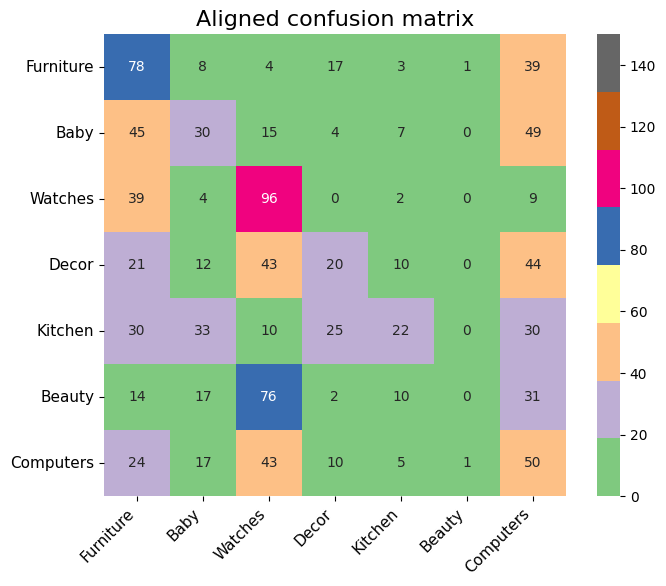

 ARI : 0.07479905405381763
              precision    recall  f1-score   support

   Furniture       0.31      0.53      0.39       150
        Baby       0.00      0.00      0.00       150
     Watches       0.33      0.64      0.44       150
       Decor       0.00      0.00      0.00       150
     Kitchen       0.31      0.53      0.39       150
      Beauty       0.00      0.00      0.00       150
   Computers       0.20      0.33      0.25       150

    accuracy                           0.29      1050
   macro avg       0.17      0.29      0.21      1050
weighted avg       0.17      0.29      0.21      1050

Clustering sur BERT


In [35]:
model=KMeans(n_clusters=7, random_state=0,n_init=30)
model.fit(bert_features_complete_description)


labels=model.labels_

title='BERT'
# Evaluate and store metrics results)
append_dict(results, {'title'   : title,
                     'metrics' : clustering_evaluate(labels, data.cat_code,cat['category'])
                     }
           )
# clustering_evaluate(labels, data.cat_code,cat['index'])
print('Clustering sur '+title)

#### USE

,cluster,effectives
Category,,
Furniture,6,94
Baby,5,83
Watches,3,141
Decor,0,271
Kitchen,4,80
Beauty,2,281
Computers,1,100


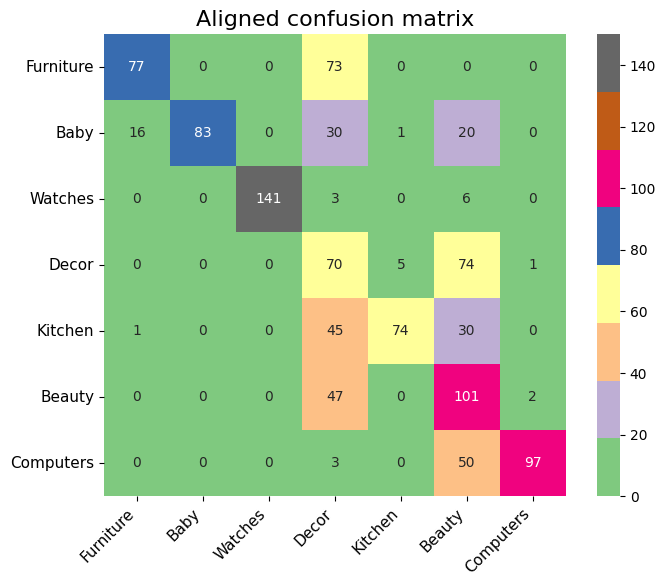

 ARI : 0.34983024821638453
              precision    recall  f1-score   support

   Furniture       0.41      1.00      0.58       150
        Baby       1.00      0.55      0.71       150
     Watches       1.00      0.94      0.97       150
       Decor       0.00      0.00      0.00       150
     Kitchen       0.93      0.49      0.64       150
      Beauty       0.36      0.67      0.47       150
   Computers       0.97      0.65      0.78       150

    accuracy                           0.62      1050
   macro avg       0.67      0.62      0.59      1050
weighted avg       0.67      0.62      0.59      1050

Clustering sur USE


In [36]:
model=KMeans(n_clusters=7, random_state=0,n_init=30)
model.fit(use_features_complete_description)


labels=model.labels_

title='USE'
# Evaluate and store metrics results)
append_dict(results, {'title'   : title,
                     'metrics' : clustering_evaluate(labels, data.cat_code,cat['category'])
                     }
           )
# clustering_evaluate(labels, data.cat_code,cat['index'])
print('Clustering sur '+title)

### Projections

#### PCA

* **Linear space transformation**: PCA projects data into a new coordinate system defined by orthogonal directions of maximum variance
* **Dimensionality optimization**: Reduces feature redundancy by identifying and preserving only the most informative dimensions
* **Noise reduction effect**: Lower-ranked components often capture noise, so eliminating them increases signal-to-noise ratio
* **Global pattern prioritization**: Emphasizes broad patterns that explain the largest sources of variation across documents
* **Feature correlation resolution**: Addresses multicollinearity by creating uncorrelated components from correlated original features
* **Variance-based information retention**: Provides clear metrics on how much information (variance) is preserved in the reduced space

##### BERT + PCA

,cluster,effectives
Category,,
Furniture,1,273
Baby,4,2
Watches,0,286
Decor,6,66
Kitchen,2,71
Beauty,5,196
Computers,3,156


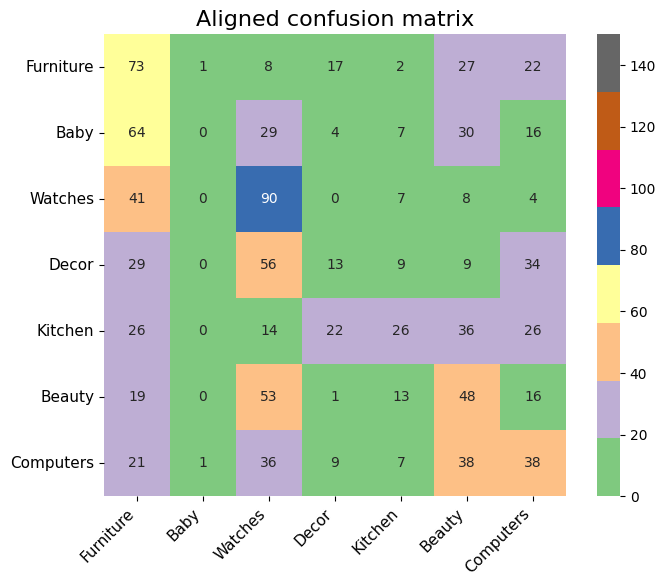

 ARI : 0.06100235535353596
              precision    recall  f1-score   support

   Furniture       0.27      0.49      0.35       150
        Baby       0.00      0.00      0.00       150
     Watches       0.31      0.60      0.41       150
       Decor       0.00      0.00      0.00       150
     Kitchen       0.35      0.32      0.33       150
      Beauty       0.24      0.32      0.28       150
   Computers       0.24      0.25      0.25       150

    accuracy                           0.28      1050
   macro avg       0.20      0.28      0.23      1050
weighted avg       0.20      0.28      0.23      1050

Clustering on BERT + PCA (2 components, 63.55% explained variance)


In [37]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Create full PCA model to calculate explained variance
pca_full = PCA(random_state=42)
pca_full.fit(bert_features_complete_description)

# Calculate cumulative variance explained by the first 2 components
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()
variance_2_components = cumulative_variance[1] * 100

# Apply PCA with 2 components for dimensionality reduction
pca = PCA(n_components=2, random_state=42)
bow_pca = pca.fit_transform(bert_features_complete_description)

# K-Means clustering on reduced data
kmeans2 = KMeans(n_clusters=7, random_state=42, n_init=30).fit(bow_pca)
labels = kmeans2.labels_

# Title including explained variance
title = f'BERT + PCA (2 components, {variance_2_components:.2f}% explained variance)'

# Evaluate and store metrics results
append_dict(results, {
    'title': title,
    'metrics': clustering_evaluate(labels, data.cat_code, cat['category'])
})

# Display clustering results
print(f'Clustering on {title}')

##### USE + PCA

,cluster,effectives
Category,,
Furniture,0,97
Baby,5,163
Watches,1,130
Decor,2,194
Kitchen,3,137
Beauty,6,157
Computers,4,172


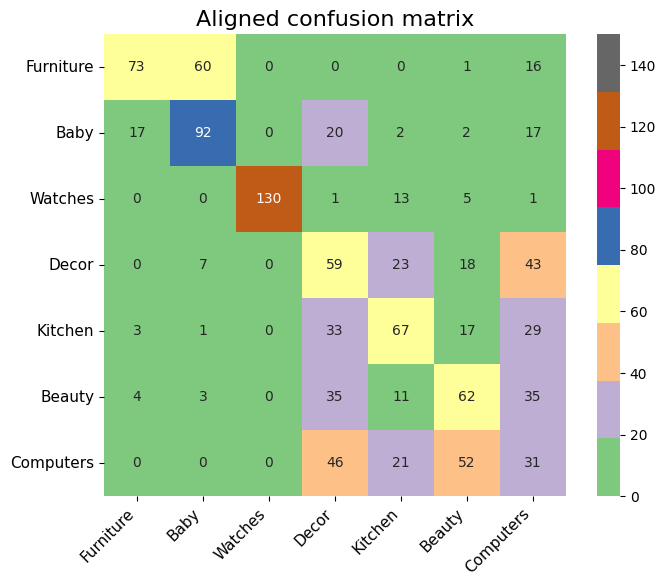

 ARI : 0.2728916416210009
              precision    recall  f1-score   support

   Furniture       0.75      0.49      0.59       150
        Baby       0.56      0.61      0.59       150
     Watches       1.00      0.87      0.93       150
       Decor       0.28      0.68      0.40       150
     Kitchen       0.49      0.45      0.47       150
      Beauty       0.39      0.41      0.40       150
   Computers       0.00      0.00      0.00       150

    accuracy                           0.50      1050
   macro avg       0.50      0.50      0.48      1050
weighted avg       0.50      0.50      0.48      1050

Clustering on USE + PCA (2 components, 17.17% explained variance)


In [38]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Create full PCA model to calculate explained variance
pca_full = PCA(random_state=42)
pca_full.fit(use_features_complete_description)

# Calculate cumulative variance explained by the first 2 components
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()
variance_2_components = cumulative_variance[1] * 100

# Apply PCA with 2 components for dimensionality reduction
pca = PCA(n_components=2, random_state=42)
bow_pca = pca.fit_transform(use_features_complete_description)

# K-Means clustering on reduced data
kmeans2 = KMeans(n_clusters=7, random_state=42, n_init=30).fit(bow_pca)
labels = kmeans2.labels_

# Title including explained variance
title = f'USE + PCA (2 components, {variance_2_components:.2f}% explained variance)'

# Evaluate and store metrics results
append_dict(results, {
    'title': title,
    'metrics': clustering_evaluate(labels, data.cat_code, cat['category'])
})

# Display clustering results
print(f'Clustering on {title}')

#### TSNE

* **Optimized spatial reorganization**: t-SNE transforms the vector space by preserving local similarities while amplifying differences between distinct groups
* **Curse of dimensionality mitigation**: Addresses the "curse of dimensionality" problem that affects high-dimensional TF-IDF vectors, where distance metrics become less meaningful
* **Adaptation to textual complexity**: Unlike linear methods, t-SNE adapts to complex and non-linear structures present in textual data
* **Dimensional noise elimination**: Reduction to 2D eliminates non-relevant dimensions that hindered K-means performance in the original sparse vector space
* **Enhancement of natural boundaries**: The transformation accentuates natural separations between categories, considerably facilitating the clustering algorithm's task

##### BERT + TSNE

,cluster,effectives
Category,,
Furniture,2,212
Baby,5,141
Watches,4,201
Decor,1,169
Kitchen,3,156
Beauty,0,121
Computers,6,50


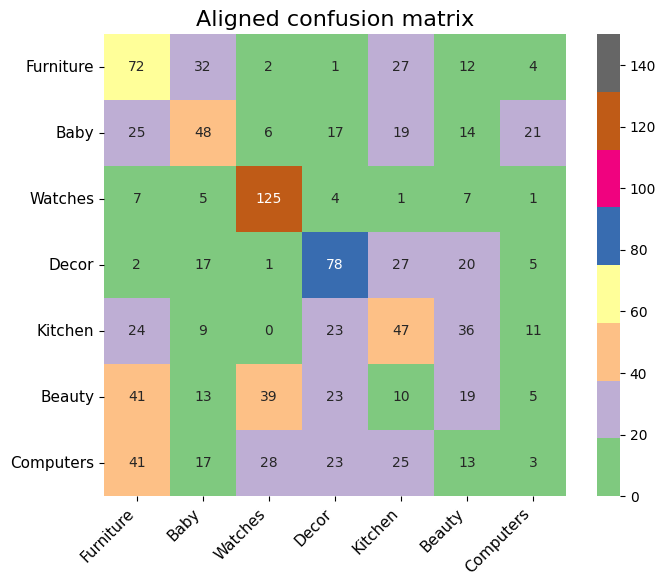

 ARI : 0.1574874917089552
              precision    recall  f1-score   support

   Furniture       0.34      0.48      0.40       150
        Baby       0.36      0.46      0.40       150
     Watches       0.62      0.83      0.71       150
       Decor       0.46      0.52      0.49       150
     Kitchen       0.30      0.55      0.39       150
      Beauty       0.00      0.00      0.00       150
   Computers       0.00      0.00      0.00       150

    accuracy                           0.41      1050
   macro avg       0.30      0.41      0.34      1050
weighted avg       0.30      0.41      0.34      1050

Clustering on BERT + T-SNE 2 components


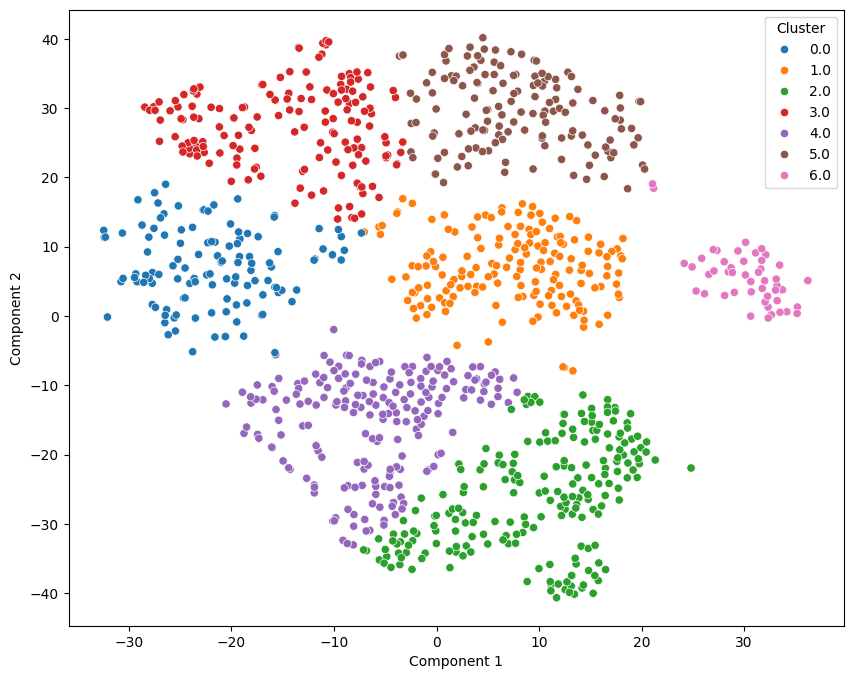

<Figure size 1000x800 with 0 Axes>

In [39]:
from sklearn.manifold import TSNE
# tok variable comes from the countvectorizer + tfidf section
bert_tsne = TSNE(n_components=2,
                perplexity=50,
                early_exaggeration=12.0,
                learning_rate=200.0,
                max_iter=1000,
                n_iter_without_progress=300,
                min_grad_norm=1e-07,
                metric='euclidean',
                init='random',   # pca
                verbose=0,
                random_state=42,
                method='barnes_hut',   # exact
                angle=0.2,
                n_jobs=-1
               ).fit_transform(bert_features_complete_description)

# Import KMeans clusterer
from sklearn.cluster import KMeans


kmeans2 = KMeans(n_clusters=7, random_state=42,n_init=30).fit(bert_tsne)
    # Assign clusters
labels=kmeans2.labels_

title='BERT + T-SNE 2 components'
# Evaluate and store metrics results)
append_dict(results, {'title'   : title,
                     'metrics' : clustering_evaluate(labels, data.cat_code,cat['category'])
                     }
           )
# clustering_evaluate(labels, data.cat_code,cat['index'])
print('Clustering on '+title)

plot_clusters(bert_tsne,labels)

##### USE + TSNE

,cluster,effectives
Category,,
Furniture,0,109
Baby,4,185
Watches,2,149
Decor,5,240
Kitchen,3,178
Beauty,6,73
Computers,1,116


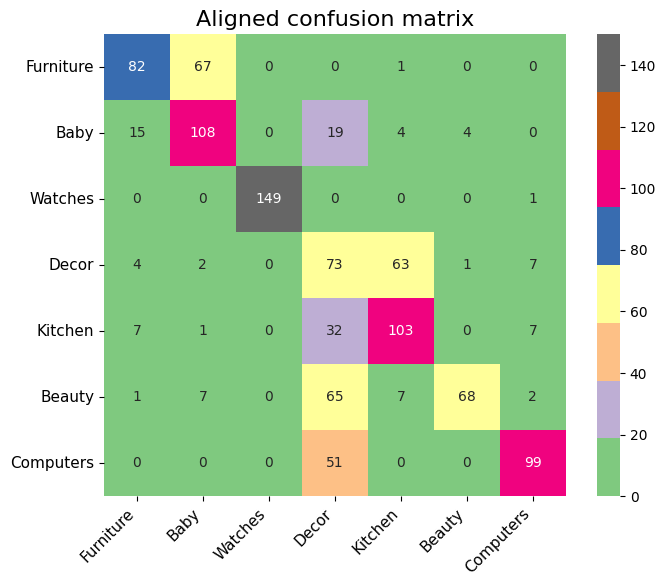

 ARI : 0.4411733574459113
              precision    recall  f1-score   support

   Furniture       0.75      0.55      0.63       150
        Baby       0.58      0.72      0.64       150
     Watches       1.00      0.99      1.00       150
       Decor       0.30      0.49      0.37       150
     Kitchen       0.58      0.69      0.63       150
      Beauty       0.93      0.45      0.61       150
   Computers       0.85      0.66      0.74       150

    accuracy                           0.65      1050
   macro avg       0.71      0.65      0.66      1050
weighted avg       0.71      0.65      0.66      1050

Clustering on USE + T-SNE 2 components


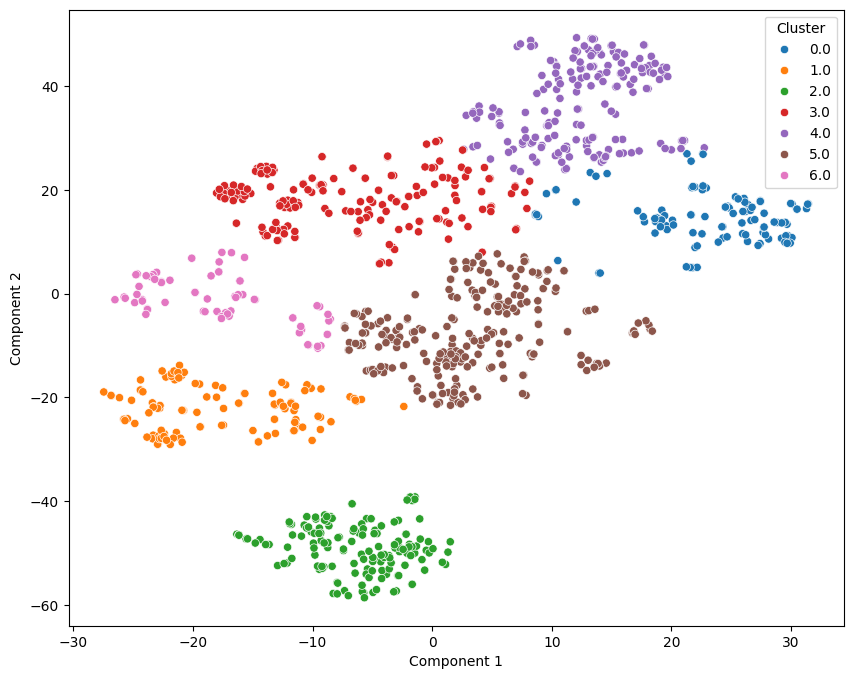

<Figure size 1000x800 with 0 Axes>

In [40]:
from sklearn.manifold import TSNE
# tok variable comes from the countvectorizer + tfidf section
use_tsne = TSNE(n_components=2,
                perplexity=50,
                early_exaggeration=12.0,
                learning_rate=200.0,
                max_iter=1000,
                n_iter_without_progress=300,
                min_grad_norm=1e-07,
                metric='euclidean',
                init='random',   # pca
                verbose=0,
                random_state=42,
                method='barnes_hut',   # exact
                angle=0.2,
                n_jobs=-1
               ).fit_transform(use_features_complete_description)

# Import KMeans clusterer
from sklearn.cluster import KMeans


kmeans2 = KMeans(n_clusters=7, random_state=42,n_init=30).fit(use_tsne)
    # Assign clusters
labels=kmeans2.labels_

title='USE + T-SNE 2 components'
# Evaluate and store metrics results)
append_dict(results, {'title'   : title,
                     'metrics' : clustering_evaluate(labels, data.cat_code,cat['category'])
                     }
           )
# clustering_evaluate(labels, data.cat_code,cat['index'])
print('Clustering on '+title)

plot_clusters(use_tsne,labels)

#### MDS

* **Distance preservation focus**: Maintains pairwise distances between documents in lower-dimensional space
* **Global relationship retention**: Preserves overall structure of document relationships
* **Similarity visualization**: Transforms abstract similarities into interpretable spatial relationships
* **Stress minimization**: Optimizes projection by minimizing distortion in distance representation
* **Metric integrity**: Provides faithful representation of original document dissimilarities
* **Euclidean interpretation**: Projected distances correspond meaningfully to original feature differences

##### BERT + MDS

,cluster,effectives
Category,,
Furniture,5,261
Baby,3,2
Watches,1,255
Decor,6,79
Kitchen,4,83
Beauty,0,185
Computers,2,185


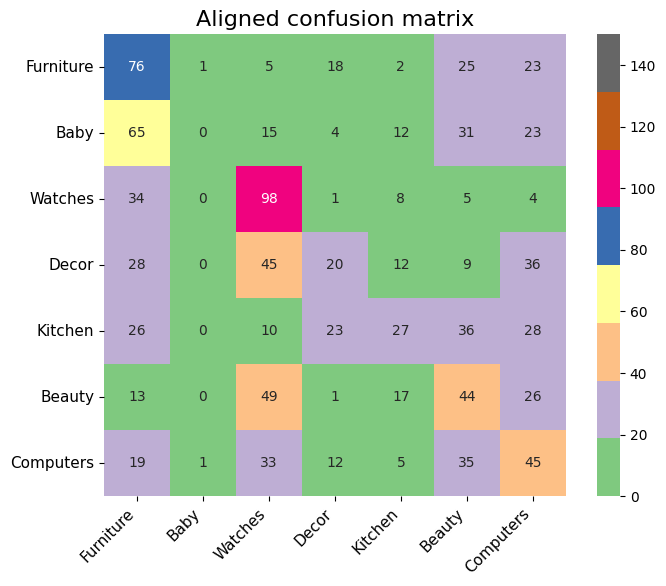

 ARI : 0.07778800641659242
              precision    recall  f1-score   support

   Furniture       0.29      0.51      0.37       150
        Baby       0.00      0.00      0.00       150
     Watches       0.38      0.65      0.48       150
       Decor       0.00      0.00      0.00       150
     Kitchen       0.31      0.33      0.32       150
      Beauty       0.24      0.29      0.26       150
   Computers       0.24      0.30      0.27       150

    accuracy                           0.30      1050
   macro avg       0.21      0.30      0.24      1050
weighted avg       0.21      0.30      0.24      1050

Clustering on BERT + MDS 2 components


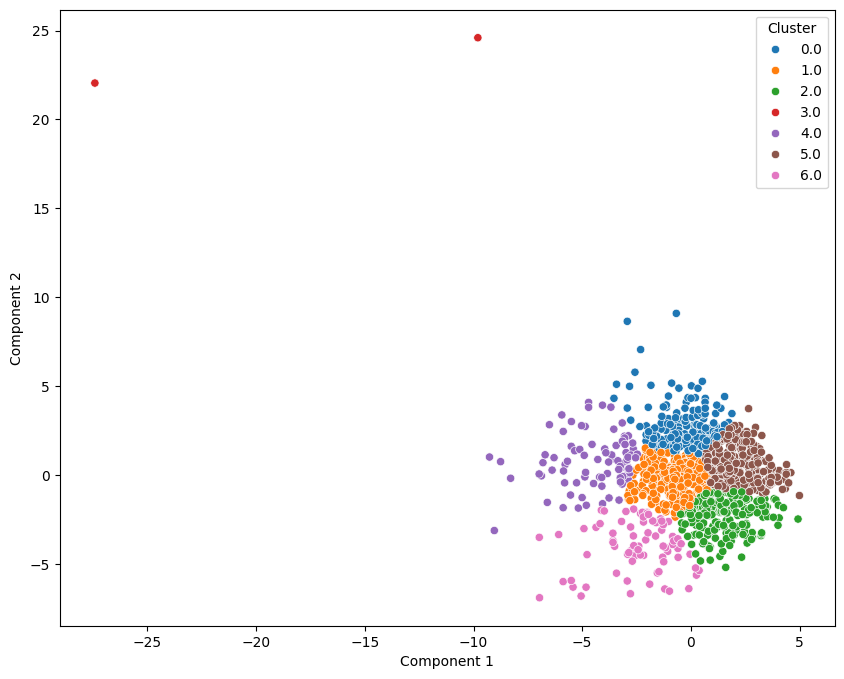

<Figure size 1000x800 with 0 Axes>

In [41]:
from sklearn.manifold import MDS
bert_mds = MDS(n_components=2,
              metric=True,
              n_init=4,
              max_iter=300,
              verbose=0,
              eps=0.001,
              n_jobs=-1,
              random_state=42,

             ).fit_transform(bert_features_complete_description)

# Import KMeans clusterer
from sklearn.cluster import KMeans


kmeans3 = KMeans(n_clusters=7, random_state=42,n_init=30).fit(bert_mds)
    # Assign clusters
labels=kmeans3.labels_

title='BERT + MDS 2 components'
# Evaluate and store metrics results)
append_dict(results, {'title'   : title,
                     'metrics' : clustering_evaluate(labels, data.cat_code,cat['category'])
                     }
           )
# clustering_evaluate(labels, data.cat_code,cat['index'])
print('Clustering on '+title)

plot_clusters(bert_mds,labels)

##### USE + MDS

,cluster,effectives
Category,,
Furniture,2,144
Baby,0,145
Watches,1,178
Decor,6,102
Kitchen,3,156
Beauty,4,156
Computers,5,169


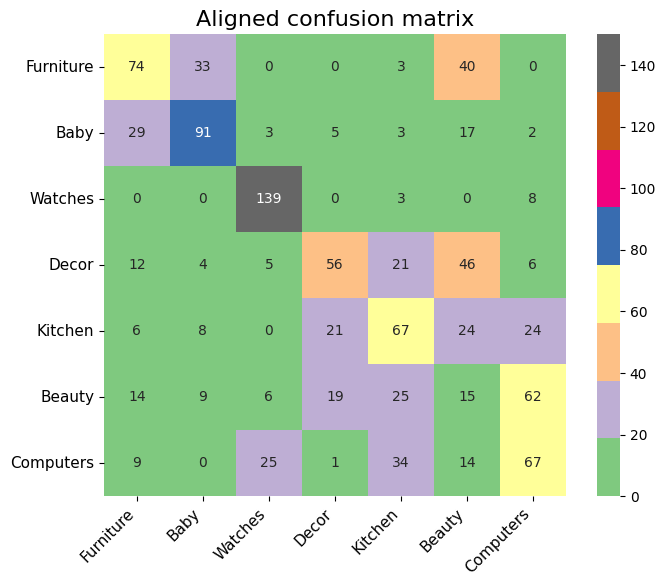

 ARI : 0.27493937901854
              precision    recall  f1-score   support

   Furniture       0.51      0.49      0.50       150
        Baby       0.63      0.61      0.62       150
     Watches       0.78      0.93      0.85       150
       Decor       0.40      0.68      0.50       150
     Kitchen       0.43      0.45      0.44       150
      Beauty       0.00      0.00      0.00       150
   Computers       0.40      0.45      0.42       150

    accuracy                           0.51      1050
   macro avg       0.45      0.51      0.48      1050
weighted avg       0.45      0.51      0.48      1050

Clustering on USE + MDS 2 components


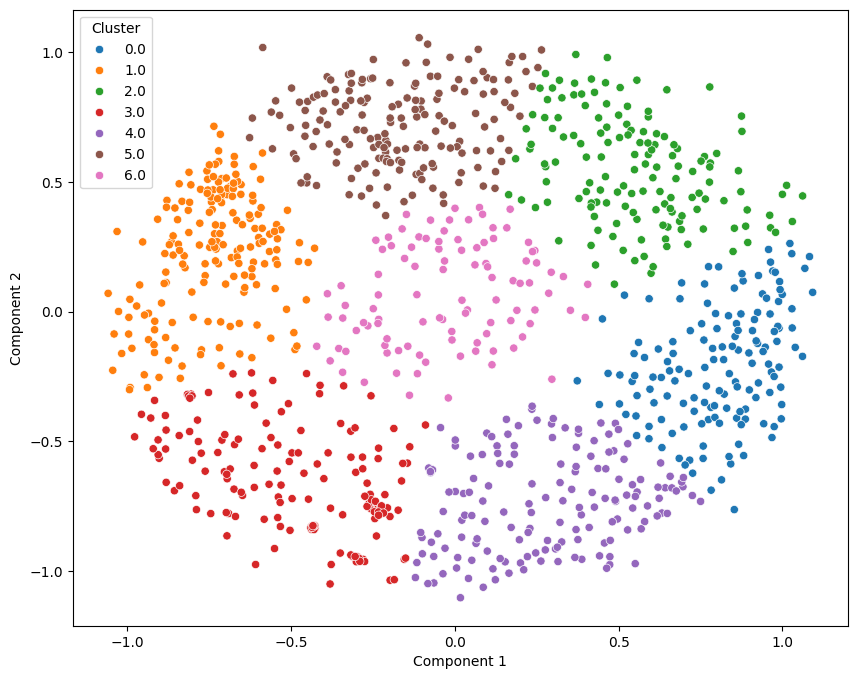

<Figure size 1000x800 with 0 Axes>

In [42]:
from sklearn.manifold import MDS
use_mds = MDS(n_components=2,
              metric=True,
              n_init=4,
              max_iter=300,
              verbose=0,
              eps=0.001,
              n_jobs=-1,
              random_state=42,

             ).fit_transform(use_features_complete_description)

# Import KMeans clusterer
from sklearn.cluster import KMeans


kmeans3 = KMeans(n_clusters=7, random_state=42,n_init=30).fit(use_mds)
    # Assign clusters
labels=kmeans3.labels_

title='USE + MDS 2 components'
# Evaluate and store metrics results)
append_dict(results, {'title'   : title,
                     'metrics' : clustering_evaluate(labels, data.cat_code,cat['category'])
                     }
           )
# clustering_evaluate(labels, data.cat_code,cat['index'])
print('Clustering on '+title)

plot_clusters(use_mds,labels)

#### SpectralEmbedding

* **Graph-based approach**: Leverages connectivity patterns between documents for dimensionality reduction
* **Non-linear manifold learning**: Captures intrinsic geometric structure of the document space
* **Eigenvector foundation**: Uses the most significant eigenvectors of the graph Laplacian matrix
* **Community detection strength**: Excels at revealing natural groupings and thematic communities
* **Connectivity preservation**: Maintains connected components from the high-dimensional space
* **Local-to-global mapping**: Builds global representation from local neighborhood information

##### BERT + SpectralEmbedding

,cluster,effectives
Category,,
Furniture,2,130
Baby,1,174
Watches,0,159
Decor,6,171
Kitchen,3,73
Beauty,5,178
Computers,4,165


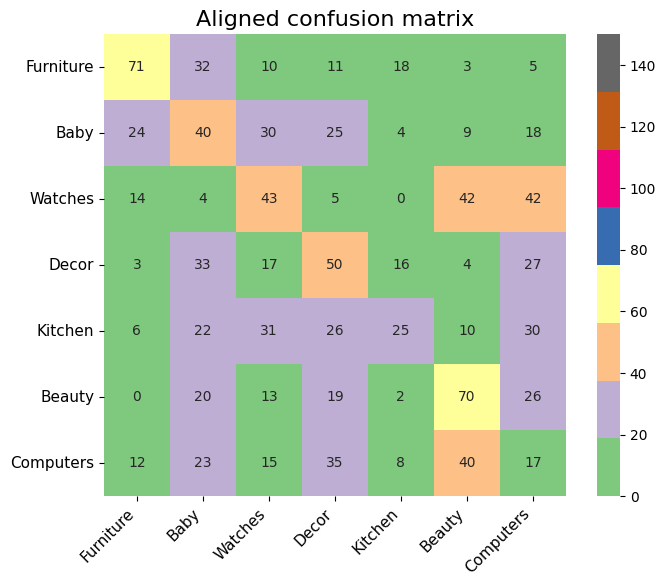

 ARI : 0.08135360756334405
              precision    recall  f1-score   support

   Furniture       0.55      0.47      0.51       150
        Baby       0.23      0.27      0.25       150
     Watches       0.26      0.57      0.36       150
       Decor       0.29      0.33      0.31       150
     Kitchen       0.34      0.17      0.22       150
      Beauty       0.39      0.47      0.43       150
   Computers       0.00      0.00      0.00       150

    accuracy                           0.32      1050
   macro avg       0.30      0.32      0.30      1050
weighted avg       0.30      0.32      0.30      1050

Clustering on BERT + Spectral 2 components


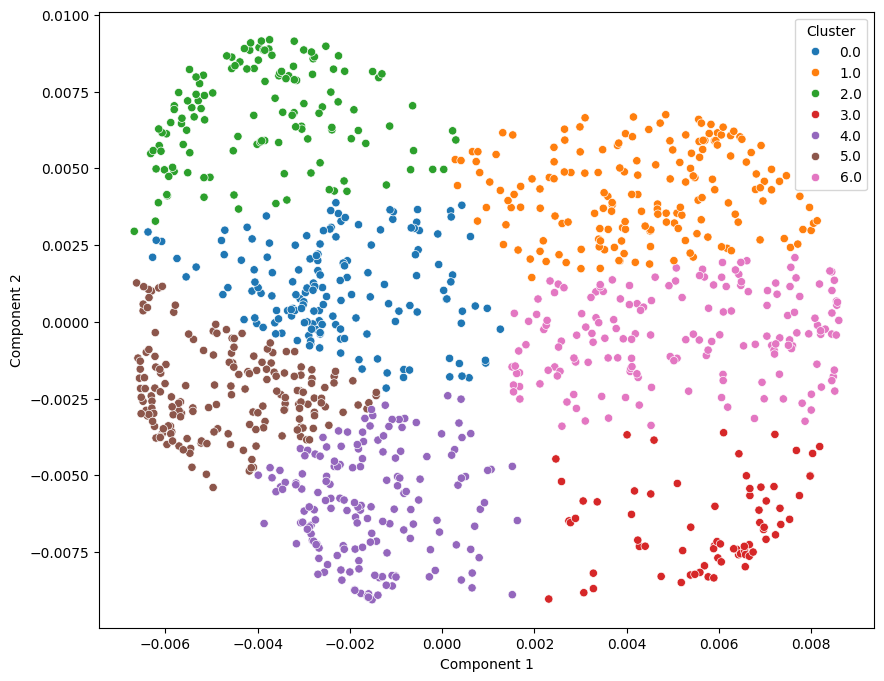

<Figure size 1000x800 with 0 Axes>

In [43]:
from sklearn.manifold import SpectralEmbedding
bert_spec = SpectralEmbedding(n_components=2,
                             affinity='nearest_neighbors', # rbf
                             gamma=None,
                             random_state=42,
                             eigen_solver=None, # arpack lobpcg amg
                             n_neighbors=50,
                             n_jobs=-1
                            ).fit_transform(bert_features_complete_description)

# Import KMeans clusterer
from sklearn.cluster import KMeans


kmeans4 = KMeans(n_clusters=7, random_state=42,n_init=30).fit(bert_spec)
    # Assign clusters
labels=kmeans4.labels_

title='BERT + Spectral 2 components'
# Evaluate and store metrics results)
append_dict(results, {'title'   : title,
                     'metrics' : clustering_evaluate(labels, data.cat_code,cat['category'])
                     }
           )
# clustering_evaluate(labels, data.cat_code,cat['index'])
print('Clustering on '+title)

plot_clusters(bert_spec,labels)

##### USE + SpectralEmbedding

,cluster,effectives
Category,,
Furniture,4,110
Baby,2,84
Watches,1,143
Decor,5,188
Kitchen,0,201
Beauty,6,12
Computers,3,312


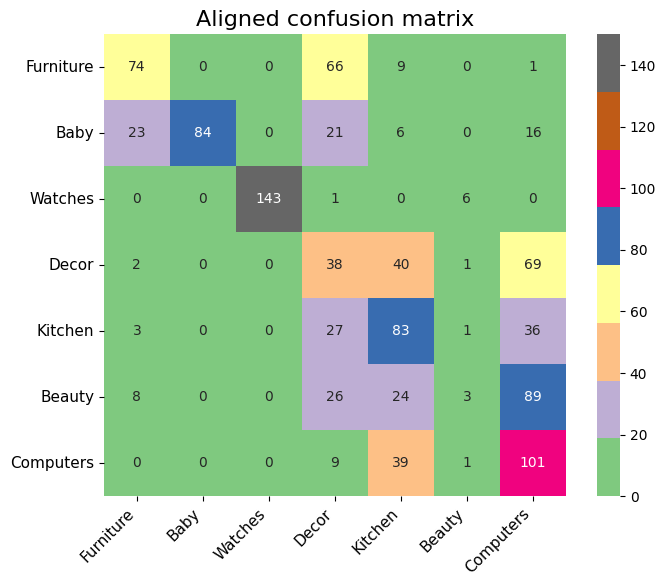

 ARI : 0.29453790343486025
              precision    recall  f1-score   support

   Furniture       0.47      0.93      0.62       150
        Baby       1.00      0.56      0.72       150
     Watches       0.96      0.99      0.98       150
       Decor       0.00      0.00      0.00       150
     Kitchen       0.41      0.55      0.47       150
      Beauty       0.00      0.00      0.00       150
   Computers       0.32      0.67      0.44       150

    accuracy                           0.53      1050
   macro avg       0.45      0.53      0.46      1050
weighted avg       0.45      0.53      0.46      1050

Clustering on USE + Spectral 2 components


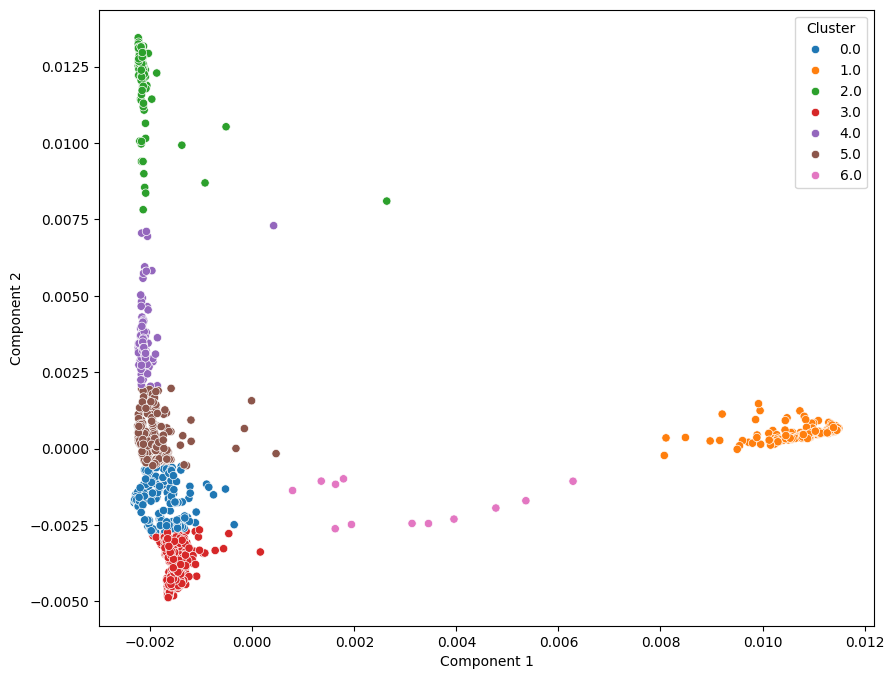

<Figure size 1000x800 with 0 Axes>

In [44]:
from sklearn.manifold import SpectralEmbedding
use_spec = SpectralEmbedding(n_components=2,
                             affinity='nearest_neighbors', # rbf
                             gamma=None,
                             random_state=42,
                             eigen_solver=None, # arpack lobpcg amg
                             n_neighbors=50,
                             n_jobs=-1
                            ).fit_transform(use_features_complete_description)

# Import KMeans clusterer
from sklearn.cluster import KMeans


kmeans4 = KMeans(n_clusters=7, random_state=42,n_init=30).fit(use_spec)
    # Assign clusters
labels=kmeans4.labels_

title='USE + Spectral 2 components'
# Evaluate and store metrics results)
append_dict(results, {'title'   : title,
                     'metrics' : clustering_evaluate(labels, data.cat_code,cat['category'])
                     }
           )
# clustering_evaluate(labels, data.cat_code,cat['index'])
print('Clustering on '+title)

plot_clusters(use_spec,labels)

#### UMAP

* **Balanced structure preservation**: Maintains both local similarity relationships and global data patterns
* **Topological foundation**: Constructs representation based on manifold topology and fuzzy simplicial sets
* **Computational efficiency**: Delivers t-SNE-like quality with significantly better performance
* **Meaningful distance preservation**: Maintains more of the important distance relationships than t-SNE
* **Theoretical rigor**: Built on stronger mathematical foundations with clearer optimization objectives
* **Cluster separation clarity**: Produces well-defined clusters while preserving their relative positions

##### BERT + UMAP

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,cluster,effectives
Category,,
Furniture,4,119
Baby,3,181
Watches,6,149
Decor,2,187
Kitchen,5,135
Beauty,0,116
Computers,1,163


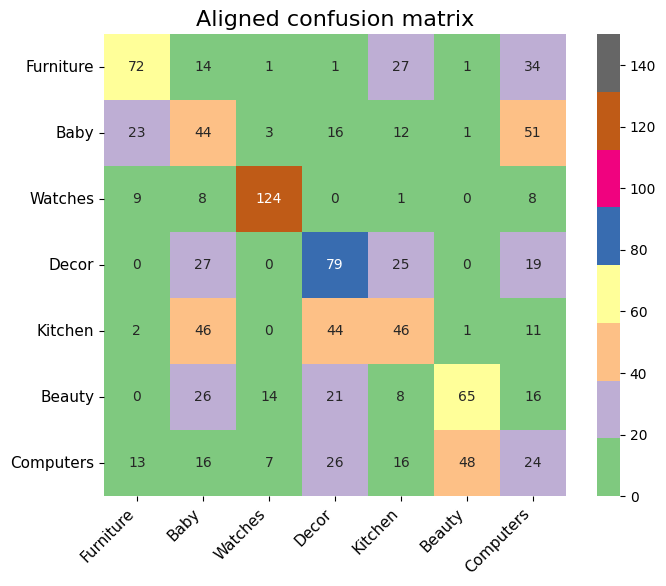

 ARI : 0.21156112143937678
              precision    recall  f1-score   support

   Furniture       0.61      0.48      0.54       150
        Baby       0.31      0.34      0.33       150
     Watches       0.83      0.83      0.83       150
       Decor       0.42      0.53      0.47       150
     Kitchen       0.29      0.61      0.39       150
      Beauty       0.56      0.43      0.49       150
   Computers       0.00      0.00      0.00       150

    accuracy                           0.46      1050
   macro avg       0.43      0.46      0.43      1050
weighted avg       0.43      0.46      0.43      1050

Clustering sur BERT + UMAP 2 components


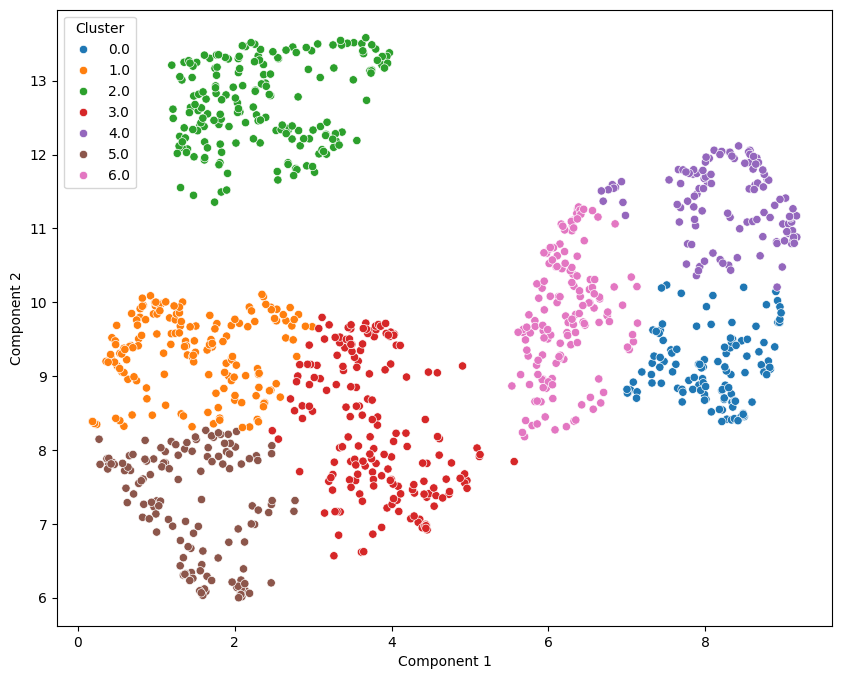

<Figure size 1000x800 with 0 Axes>

In [45]:
import umap

Umap = umap.UMAP(
                n_neighbors=50,
                min_dist=0.1,
                n_components=2,
                metric='euclidean',
                random_state=42
    )
bert_umap = Umap.fit_transform(bert_features_complete_description)

kmeans5 = KMeans(n_clusters=7, random_state=42,n_init=30).fit(bert_umap)
    # Assign clusters
labels=kmeans5.labels_

title='BERT + UMAP 2 components'
# Evaluate and store metrics results)
append_dict(results, {'title'   : title,
                     'metrics' : clustering_evaluate(labels, data.cat_code,cat['category'])
                     }
           )
# clustering_evaluate(labels, data.cat_code,cat['index'])
print('Clustering sur '+title)

plot_clusters(bert_umap,labels)

##### USE + UMAP

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,cluster,effectives
Category,,
Furniture,2,181
Baby,5,93
Watches,1,149
Decor,0,227
Kitchen,3,123
Beauty,6,138
Computers,4,139


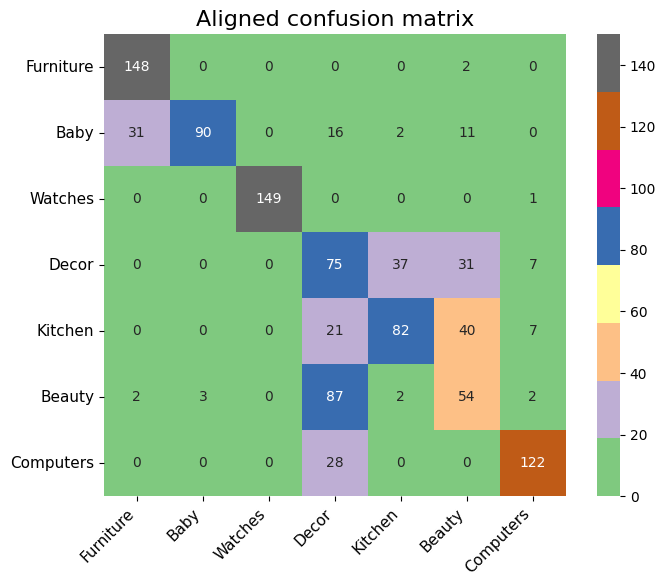

 ARI : 0.518693425026532
              precision    recall  f1-score   support

   Furniture       0.82      0.99      0.89       150
        Baby       0.97      0.60      0.74       150
     Watches       1.00      0.99      1.00       150
       Decor       0.00      0.00      0.00       150
     Kitchen       0.67      0.55      0.60       150
      Beauty       0.39      0.94      0.55       150
   Computers       0.88      0.81      0.84       150

    accuracy                           0.70      1050
   macro avg       0.67      0.70      0.66      1050
weighted avg       0.67      0.70      0.66      1050

Clustering sur USE + UMAP 2 components


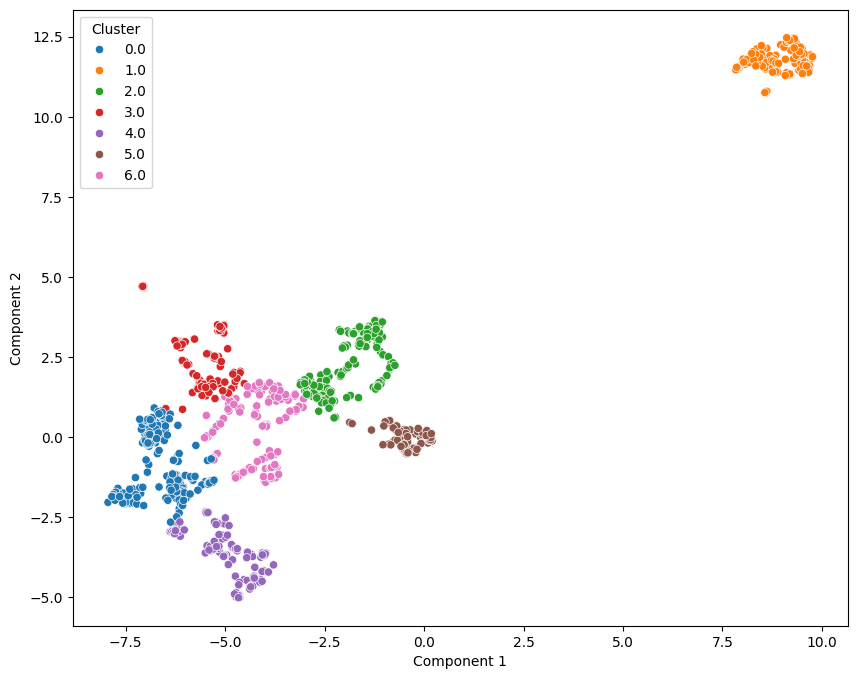

<Figure size 1000x800 with 0 Axes>

In [46]:
import umap

Umap = umap.UMAP(
                n_neighbors=50,
                min_dist=0.1,
                n_components=2,
                metric='euclidean',
                random_state=42
    )
use_umap = Umap.fit_transform(use_features_complete_description)

kmeans5 = KMeans(n_clusters=7, random_state=42,n_init=30).fit(use_umap)
    # Assign clusters
labels=kmeans5.labels_

title='USE + UMAP 2 components'
append_dict(results, {'title'   : title,
                     'metrics' : clustering_evaluate(labels, data.cat_code,cat['category'])
                     }
           )
# clustering_evaluate(labels, data.cat_code,cat['index'])
print('Clustering sur '+title)

plot_clusters(use_umap,labels)

# Résultats

In [47]:
# Create data frame from resluts dictionaryy


def highlight_max(s):
    '''
    highlight the maximum in a Series green.
    '''
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]
def highlight_min(s):
    '''
    highlight the minmum in a Series red.
    '''
    is_max = s == s.min()
    return ['background-color: lightcoral' if v else '' for v in is_max]


# unpack tuples and create result data frame
def dict_to_df(dic):
    # dict to data frame
    results_all=pd.DataFrame(dic)
    # unpack metrics tuple
    results_all['precision']=[tup[0][0] for tup in results_all.metrics]
    results_all['recall']=[tup[0][1] for tup in results_all.metrics]
    results_all['f1_score']=[tup[0][2] for tup in results_all.metrics]
    results_all['ARI']=[tup[1] for tup in results_all.metrics]
    # drop tuples
    results_all.drop(['metrics'],axis=1,inplace=True)
    # set title as index
    results_all.set_index('title',inplace=True)
#     # columns to highligth
#     subset=['precision','recall','f1_score','ARI']
    # return dataframe
    return results_all.style.apply(highlight_max).apply(highlight_min).format('{:.2%}')


results_product_name = dict_to_df(results)
results_product_name

,precision,recall,f1_score,ARI
title,,,,
BERT,16.50%,29.05%,21.03%,7.48%
USE,66.65%,61.52%,59.32%,34.98%
"BERT + PCA (2 components, 63.55% explained variance)",20.32%,28.38%,23.16%,6.10%
"USE + PCA (2 components, 17.17% explained variance)",49.71%,50.10%,48.20%,27.29%
BERT + T-SNE 2 components,29.77%,40.67%,34.18%,15.75%
USE + T-SNE 2 components,71.48%,64.95%,66.16%,44.12%
BERT + MDS 2 components,20.95%,29.90%,24.41%,7.78%
USE + MDS 2 components,44.91%,51.43%,47.51%,27.49%
BERT + Spectral 2 components,29.52%,32.48%,29.65%,8.14%


In [48]:
print(' Executé en : ', datetime.timedelta(seconds=(time.time() - start_time)))

 Executé en :  0:15:28.971406
